# Document Tagging: BBC News Articles 

This corpus used in this project includes 2,225 documents from BBC's news website corresponding to stories in five topical areas (business, entertainment, politics, sport, tech) from 2004-2005. 

The CSV file includes two columns: category (the five class labels) and text (pre-processed article content). In this project, I will use only the text column.

More information on this data set as well as a paper written using this data set is available here http://mlg.ucd.ie/datasets/bbc.html.

## Data Prep

### Import Libraries

In [1]:
import pprint
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim

import random
random.seed(42)

### Load Data

In [2]:
df = pd.read_csv("data/BBC-articles.csv")
df = df[['text']][:100]
df.head(3)

,text
0,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...
2,tigers wary of farrell gamble leicester say ...


### Initial Prep

In [3]:
'''
This function takes as input a df and name of column (containing sentences) in the df.
The input is split to tokens which are lemmatized, and stopwords removed.
The output is a list of lists.  
'''
import re
def preprocess_text(text):    
    cleanTokens=[]
    lem = WordNetLemmatizer()
    stop = set(stopwords.words('english'))

    for txt in text:
        words = [lem.lemmatize(w) for w in word_tokenize(txt) if (w not in stop) and len(w)>2]
        cleanTokens.append(words)        

    return cleanTokens


df['cleanTokens'] = preprocess_text(df.text)

## Modeling

In [4]:
# Getting tokens to use with Gensim
tokens = df.cleanTokens.to_list()

In [5]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# TF-IDF with basic cleaning
dictionaryLtd = Dictionary(tokens)
dtmLtd = [dictionaryLtd.doc2bow(doc) for doc in tokens]
tfidfVectorizerLtd = TfidfModel(dtmLtd) 
tfidfLtd = tfidfVectorizerLtd[dtmLtd]

# TF-IDF with term frequency filter cleaning
dictionaryFiltered = Dictionary(tokens)
dictionaryFiltered.filter_extremes(no_below=5, no_above=0.90)
dtmFiltered = [dictionaryFiltered.doc2bow(doc) for doc in tokens]
tfidfVectorizerFiltered = TfidfModel(dtmFiltered) 
tfidfFiltered = tfidfVectorizerFiltered[dtmFiltered]

# TF-IDF with only nouns, noun phrases and NER
dictionaryNouns = Dictionary(tokens)
dtmNouns = [dictionaryNouns.doc2bow(doc) for doc in tokens]
tfidfVectorizerNouns = TfidfModel(dtmNouns) 
tfidfNouns = tfidfVectorizerNouns[dtmNouns]

### LSI

In [9]:
from gensim.models import LsiModel, CoherenceModel

# tfidfLtd
lsi_Ltd = LsiModel(corpus=tfidfLtd, id2word=dictionaryLtd, num_topics=10)

# tfidfFiltered
lsi_Filtered = LsiModel(corpus=tfidfFiltered, id2word=dictionaryFiltered, num_topics=10)

# tfidfNouns
lsi_Nouns = LsiModel(corpus=tfidfNouns, id2word=dictionaryNouns, num_topics=10)

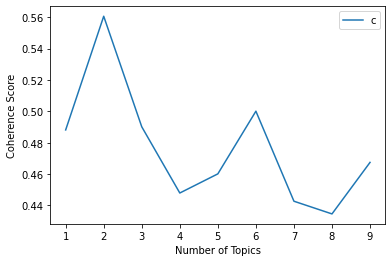

In [10]:
# Determining optimum number of topics using coherence values for tfidfLtd

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LsiModel(tfidfLtd, id2word=dictionaryLtd, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryLtd, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF the best model is when topics = 2

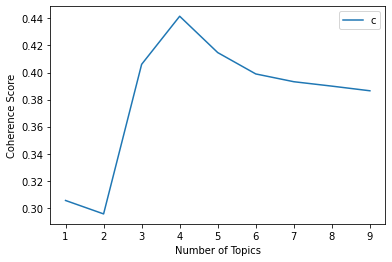

In [11]:
# Determining optimum number of topics using coherence values for tfidfFiltered

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LsiModel(tfidfFiltered, id2word=dictionaryFiltered, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryFiltered, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF using filtered data the best model is when topics = 4

In [ ]:
# Determining optimum number of topics using coherence values for tfidfNouns

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LsiModel(tfidfNouns, id2word=dictionaryNouns, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryNouns, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

### LDA

In [12]:
from gensim.models import LdaModel, LdaMulticore

# tfidfLtd
lda_Ltd = LdaModel(corpus=tfidfLtd, id2word=dictionaryLtd, num_topics=10)

# tfidfFiltered
lda_Filtered = LdaModel(corpus=tfidfFiltered, id2word=dictionaryFiltered, num_topics=10)

# tfidfNouns
lda_Nouns = LdaModel(corpus=tfidfNouns, id2word=dictionaryNouns, num_topics=10)

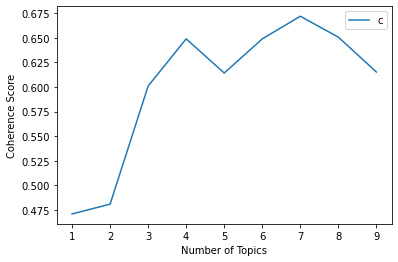

In [13]:
# Determining optimum number of topics using coherence values for tfidfLtd 

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LdaModel(tfidfLtd, id2word=dictionaryLtd, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryLtd, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF using unfiltered data the best model is when topics = 7

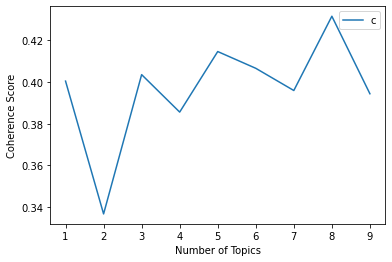

In [14]:
# Determining optimum number of topics using coherence values for tfidfFiltered

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LdaModel(tfidfFiltered, id2word=dictionaryFiltered, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryFiltered, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF using unfiltered data the best model is when topics = 7

In [ ]:
# Determining optimum number of topics using coherence values for tfidfFiltered

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LdaModel(tfidfNouns, id2word=dictionaryNouns, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryNouns, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

## Top keywords

In [7]:
# Top keywords in each topic
keywords = []

for i in range(len(tfidfLtd)):    
    for index, score in sorted(lda_Ltd[tfidfLtd[i]], key=lambda tup: -1*tup[1]):
        elements = lda_Ltd.print_topic(index, 5).split("+")
        keywords.append([x.strip().replace('"', '').split("*")[1] for x in elements])


# testing on a select output using LDA TF-IDF model
x = 0
for index, score in sorted(lda_Ltd[tfidfLtd[x]], key=lambda tup: -1*tup[1]):
    print("\nTopic No: {}\t\nScore: {}\t\nTopic Model: {}".format(index, score, lda_Ltd.print_topic(index, 5)))


Topic No: 0	
Score: 0.9337336421012878	
Topic Model: 0.001*"fiat" + 0.001*"sayeed" + 0.001*"west" + 0.001*"tobacco" + 0.001*"henman"


### LDA Interactive

In [ ]:
# interacting with LDA output
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_Ltd, tfidfLtd, dictionaryLtd)
vis

In [ ]:
# Evaluating LDA models: Topic coherence
from gensim.models import CoherenceModel

goodLdaModel = LdaModel(corpus=bow_corpus, id2word=dic_bow, iterations=50, num_topics=2)
badLdaModel = LdaModel(corpus=bow_corpus, id2word=dic_bow, iterations=1, num_topics=2)

goodcm = CoherenceModel(model=goodLdaModel, corpus=bow_corpus, dictionary=dic_bow, coherence='u_mass')
badcm  = CoherenceModel(model=badLdaModel, corpus=bow_corpus, dictionary=dic_bow, coherence='u_mass')

In [ ]:
goodcm = CoherenceModel(model=goodLdaModel, texts=bow_corpus, dictionary=dic_bow, coherence='c_v')
badcm  = CoherenceModel(model=badLdaModel, texts=bow_corpus, dictionary=dic_bow, coherence='c_v')